In [1]:
from tqdm import tqdm 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pickle
import os
pd.set_option("display.max_rows", 10000, "display.max_columns", 10000)

sns.set(context='paper', 
        style='darkgrid', 
        rc={'figure.facecolor':'white'}, 
        font_scale=1.2)




In [2]:
def FormatNames(player_df): 
    '''format all the player names to make sure the names between the stats
    and the salary are the exact same in terms of formatting, so they can
    be joined with no error'''
    
    player_df.Player = player_df.Player.str.strip(
            ).str.replace(' ', '_').str.lower().str.replace(
                r"[^a-zA-Z\d\_]+", "").str.replace(
                    r"[^a-zA-Z\d\_]+", "")
    return player_df

In [3]:
def FormatStats(stats): 
    ''' We want to get rid of the empty rows from the player stats. 
    We also want to fill in stats that are blank (insufficient info to
    get season averages to be 0. This is because if the player doesn't get 
    anything for a certain stat, it means they can be considered to be very 
    poor in that category since they have 0 attempts ''' 


    
    stats.columns[1:-1]
    stats = stats.dropna(
    subset = stats.columns[1:-1], 
    how = 'all')
    stats = stats.fillna(0) 
    stats = stats[stats.Tm != 'TOT']
    stats[stats['3P%'] > 0.454] = 0
    
    
    
    return stats 

In [4]:
def ReadPlayerFiles(): 
    
    '''Read in the player files and the stats files, format the player names'''
    player_stats = pd.read_csv('csv_files/player_stats.csv', index_col = 0)
    player_salary = pd.read_csv('csv_files/player_salary.csv', index_col = 0) 
    
    
    ''' Formats the player names so they are the same for both dataframes'''
    player_stats = FormatNames(player_stats) 
    player_salary = FormatNames(player_salary) 
    
    '''convert salary columns to numeric'''
    formatsalary = lambda x: x.str.replace('$','').str.replace(',','').astype(int)
    player_salary['Salary'] =formatsalary(player_salary.Salary)
    player_salary['adjusted_salary'] = formatsalary(player_salary.adjusted_salary)
    
    '''Format the player stats'''
    player_stats = FormatStats(player_stats) 
    
    '''Join the player data'''
    player = player_salary.merge(player_stats, on = ['Player', 'year'])
    
    first_columns = ['Player', 'year', 'Pos', 'Tm', 'Salary', 'adjusted_salary']
    
    cols = [column for column in player.columns.to_list() if column not in first_columns]
    cols = first_columns + cols
    
    player = player[cols]
    

    return player

player = ReadPlayerFiles()

In [5]:
from sklearn.preprocessing import MinMaxScaler

def NormalizeData(player_data): 
    
    player = player_data.copy() 
    player_year_group = player.groupby(['Player', 'year']) 

    str_cols = player.iloc[:,2:4].columns.to_list() 
    numeric_cols = player.iloc[:,4:].columns.to_list() 

    str_group = player_year_group.apply(lambda x: x[str_cols].tail(1)).reset_index()
    stats_group = player_year_group.apply(lambda x: np.average(x[numeric_cols], 
                                             weights = x.G,
                                                axis = 0)).reset_index() 


    yearly_normalized =str_group.merge(stats_group,
                            on = ['Player', 'year'])
    yearly_normalized[numeric_cols] = yearly_normalized[0].apply(pd.Series)
    yearly_normalized = yearly_normalized.drop([0, 'level_2'], axis = 1)

    year_group = pd.concat([
        yearly_normalized.iloc[:,0:4], 
        yearly_normalized.groupby(['year'])[numeric_cols].transform(
            lambda x: (x - x.mean()) / x.std() ) 
        ], axis = 1) 

    ## Normalize all features
    year_group.iloc[:,4:] = MinMaxScaler().fit_transform(year_group.iloc[:,4:])
    
    return year_group
year_group = NormalizeData(player)

4


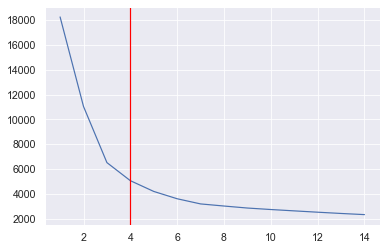

In [13]:
from sklearn.cluster import KMeans 
from kneed import KneeLocator 

def FindKMeans(data): 
    
    sum_squared_distances = [] 
    clusters = range(1,15)  
    for cluster in clusters: 
        kmeans = KMeans(n_clusters = cluster)
        kmeans = kmeans.fit(data) 
        sum_squared_distances.append(kmeans.inertia_) 
    
    knee = KneeLocator(clusters, sum_squared_distances, 
                    curve = 'convex', direction = 'decreasing') 
    
    print(knee.knee) 
    ax = sns.lineplot(x = clusters, y = sum_squared_distances) 
    ax.axvline(knee.knee, color = 'red') 
    
    return KMeans(n_clusters = knee.knee).fit(data) 

player_kmeans = FindKMeans(year_group.iloc[:,6:])

3


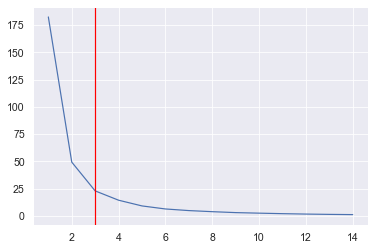

In [14]:
year_group['player_cluster'] = player_kmeans.labels_
year_group['salary_cluster'] = FindKMeans(year_group.adjusted_salary.to_numpy(
).reshape(-1,1)).labels_
year_group_clusters = year_group.groupby(['player_cluster']).agg(['mean', 'max', 'min', 'std'])

In [15]:
def ClusterOrders(year_group): 
    
    year_group_cluster = year_group.groupby(['player_cluster']).agg(['mean'])
    
    cluster = {} 
    
    columns = np.array(year_group_cluster.columns.to_list())
    
    for colname in columns:
        order_by = year_group_cluster.sort_values(by = tuple(colname), 
                                                 ascending = False) 
        
        cluster[colname[0]] = order_by.index
    
    cluster = pd.DataFrame().from_dict(cluster) 
    
    return cluster 

cluster = ClusterOrders(year_group_clusters)
cluster

,year,Salary,adjusted_salary,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,salary_cluster
0,3,3,3,1,2,2,2,2,2,1,3,3,2,3,3,1,1,3,3,1,3,3,3,3,2,3,3,2,2,3
1,0,0,0,0,1,0,0,3,3,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,3,2,2,1,3,0
2,1,2,2,3,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2,1,1,2,3,1,3,1,1,3,1,1,3,1,1,3,3,1,1,3,1,1,1,1,1,1,1,3,1,2


In [16]:
year_group_clusters

year                          Salary           \
                       mean   max   min       std      mean      max   
player_cluster                                                         
0               2010.505798  2020  2000  6.267349  0.091337  0.70306   
1               2010.381660  2020  2000  6.232458  0.049081  0.68829   
2               2009.955016  2020  2000  6.190838  0.227041  0.35814   
3               2010.455250  2020  2000  6.271249  0.299185  1.00000   

                                   adjusted_salary                     \
                     min       std            mean      max       min   
player_cluster                                                          
0               0.008772  0.098054        0.091337  0.70306  0.008772   
1               0.000000  0.056395        0.049081  0.68829  0.000000   
2               0.144453  0.059252        0.227041  0.35814  0.144453   
3               0.011563  0.218611        0.299185  1.00000  0.011563   

                               Age                                       G  \
                     std      mean       max       min       std      mean   
player_cluster                                                               
0               0.098054  0.311901  1.000000  0.024386  0.158694  0.720251   
1               0.056395  0.301145  0.895983  0.000000  0.162128  0.325176   
2               0.059252  0.394057  0.884776  0.035364  0.134873  0.698416   
3               0.218611  0.312841  0.810098  0.035364  0.144030  0.802411   

                                                    GS                      \
                     max       min       std      mean       max       min   
player_cluster                                                               
0               0.987690  0.036015  0.185365  0.219989  0.916541  0.000000   
1               0.925493  0.000000  0.191768  0.041800  0.332359  0.000000   
2               1.000000  0.036015  0.224640  0.434551  1.000000  0.000000   
3               0.987690  0.059168  0.152001  0.735520  1.000000  0.028292   

                                MP                                      FG  \
                     std      mean       max       min       std      mean   
player_cluster                                                               
0               0.198269  0.505071  0.957974  0.228915  0.112040  0.243224   
1               0.044136  0.247151  0.642637  0.000000  0.099173  0.106191   
2               0.323533  0.625361  0.995165  0.071969  0.187611  0.335862   
3               0.181528  0.802677  1.000000  0.464477  0.085796  0.523348   

                                                   FGA                      \
                     max       min       std      mean       max       min   
player_cluster                                                               
0               0.539018  0.050894  0.078091  0.251178  0.592462  0.058956   
1               0.321645  0.000000  0.051317  0.117426  0.391852  0.000000   
2               0.890033  0.007327  0.156407  0.337595  0.873782  0.017384   
3               1.000000  0.199850  0.144271  0.513787  1.000000  0.206884   

                               FG%                                      3P  \
                     std      mean       max       min       std      mean   
player_cluster                                                               
0               0.080118  0.459732  0.681107  0.182773  0.047913  0.164697   
1               0.051417  0.419904  1.000000  0.000000  0.116323  0.068266   
2               0.153472  0.467379  0.952540  0.062073  0.057194  0.185605   
3               0.140898  0.479777  0.680399  0.383024  0.041425  0.244865   

                                              3PA                           \
                     max  min       std      mean       max  min       std   
player_cluster                                                               
0               0.679123  0.0  0.1137

In [17]:
GroupByCluster = lambda df, cluster: df[df.player_cluster == cluster]
FindMinMax = lambda df, cluster_list, col, num, min = True: df[df.player_cluster.isin(cluster_list)].sort_values(by = [col], ascending = min).head(num)


FindMinMax(year_group, [0,1,2,3,4],'3PA', 100, min = False)

,Player,year,Pos,Tm,Salary,adjusted_salary,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,player_cluster,salary_cluster
3418,james_harden,2019,PG,HOU,0.582355,0.582355,0.439387,0.940583,0.953490,0.950673,0.884123,0.929101,0.458790,0.813732,1.000000,0.764773,0.570334,0.618321,0.494043,0.512335,1.000000,0.962509,0.857858,0.178538,0.492625,0.400621,0.634704,0.752855,0.206623,0.884635,0.690861,1.000000,3,0
7253,stephen_curry,2016,PG,GSW,0.328699,0.328699,0.342715,0.892590,0.880387,0.856624,0.880414,0.784659,0.507973,1.000000,0.983319,0.941323,0.481645,0.458062,0.541538,0.611878,0.473189,0.437667,0.891266,0.191503,0.403757,0.333842,0.571588,0.738980,0.064583,0.577965,0.473133,0.884190,2,2
647,baron_davis,2004,PG,NOH,0.396993,0.396993,0.212185,0.761504,0.711205,0.918575,0.702548,0.767248,0.426816,0.703244,0.919594,0.785913,0.479680,0.537857,0.480501,0.491329,0.341252,0.422683,0.679562,0.168160,0.298016,0.255324,0.642408,0.814296,0.111530,0.529858,0.562938,0.669298,3,0
3419,james_harden,2020,SG,HOU,0.669886,0.669886,0.500886,0.926140,0.922781,0.926791,0.788278,0.817929,0.453609,0.701494,0.888353,0.724752,0.518875,0.538764,0.504720,0.508180,0.976732,0.971356,0.839604,0.214471,0.471151,0.404958,0.627503,0.678663,0.268821,0.757841,0.736093,0.913601,3,0
7256,stephen_curry,2019,PG,GSW,0.708509,0.708509,0.476530,0.846506,0.848842,0.873617,0.755376,0.738249,0.479599,0.864211,0.887022,0.899481,0.386553,0.427584,0.492202,0.555524,0.403388,0.378194,0.888538,0.161178,0.402061,0.323956,0.441568,0.494086,0.121044,0.512088,0.548539,0.759643,3,0
513,antoine_walker,2001,PF,BOS,0.421252,0.421252,0.198032,0.897662,0.866422,0.958832,0.719992,0.771703,0.440942,0.725601,0.881754,0.844021,0.497089,0.583203,0.470000,0.501762,0.294947,0.332465,0.722188,0.315775,0.593346,0.508244,0.459896,0.573896,0.150258,0.626470,0.621761,0.667423,3,0
6451,ray_allen,2006,SG,SEA,0.460512,0.460512,0.448874,0.878964,0.836099,0.882902,0.705258,0.706774,0.467338,0.787961,0.877736,0.916499,0.449933,0.487886,0.496505,0.541254,0.362774,0.328609,0.907663,0.168821,0.301040,0.264799,0.323074,0.470016,0.073258,0.417110,0.388967,0.686479,3,0
514,antoine_walker,2002,PF,BOS,0.448062,0.448062,0.254673,0.907979,0.873779,0.962813,0.674852,0.758747,0.424740,0.675175,0.873950,0.823168,0.464487,0.555731,0.454655,0.487241,0.300299,0.330022,0.741773,0.315028,0.617886,0.520375,0.412148,0.500922,0.127611,0.534235,0.600424,0.637155,3,0
6447,ray_allen,2002,SG,MIL,0.448062,0.448062,0.287540,0.779148,0.725697,0.844689,0.635235,0.608401,0.487332,0.812786,0.843944,0.966936,0.373396,0.390716,0.510711,0.577863,0.310171,0.297189,0.872893,0.202805,0.301414,0.270208,0.324913,0.437744,0.084100,0.399228,0.485900,0.628788,3,0
515,antoine_walker,2003,PF,BOS,0.463798,0.463798,0.287983,0.842132,0.812208,0.956327,0.641870,0.729965,0.422652,0.617907,0.832394,0.775282,0.457711,0.549651,0.462263,0.481198,0.222351,0.295273,0.615795,0.220578,0.526183,0.432621,0.416709,0.505161,0.110107,0.559412,0.573852,0.577807,3,0


In [18]:
year_group_2.salary_cluster.value_counts()

0    2393
2     255
1      28
Name: salary_cluster, dtype: int64

In [19]:
player[(player['3P%'] ==0)].sort_values(by = ['3P'], ascending = False).head()

,Player,year,Pos,Tm,Salary,adjusted_salary,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,shaquille_oneal,2000,C,LAL,17142858,26420114,27.0,79.0,79.0,40.0,12.1,21.1,0.574,0.0,0.0,0.0,12.1,21.1,0.575,0.574,5.5,10.4,0.524,4.3,9.4,13.6,3.8,0.5,3.0,2.8,3.2,29.7
5135,jajuan_johnson,2012,PF,BOS,1042320,1182795,22.0,36.0,0.0,8.3,1.5,3.4,0.446,0.0,0.0,0.0,1.5,3.4,0.446,0.446,0.2,0.3,0.667,0.6,1.1,1.6,0.2,0.1,0.4,0.4,0.7,3.2
5103,reggie_evans,2012,PF,LAC,1229255,1394924,31.0,56.0,0.0,13.8,0.6,1.3,0.472,0.0,0.0,0.0,0.6,1.3,0.472,0.472,0.6,1.3,0.507,1.8,3.1,4.8,0.3,0.6,0.1,0.8,2.1,1.9
5104,eddy_curry,2012,C,MIA,1229255,1394924,29.0,14.0,1.0,5.9,0.9,1.9,0.462,0.0,0.0,0.0,0.9,1.9,0.462,0.462,0.4,0.6,0.750,0.3,0.6,0.9,0.1,0.0,0.1,0.7,1.2,2.1
5110,marquis_daniels,2012,SG,BOS,1223166,1388014,31.0,38.0,0.0,12.7,1.4,3.8,0.364,0.0,0.3,0.0,1.4,3.5,0.391,0.364,0.4,0.6,0.739,0.4,1.3,1.7,1.2,0.6,0.2,0.7,0.9,3.2
